In [1]:
from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output

clear_output()

In [5]:
model = LanguageModel("openai-community/gpt2", device_map="auto", dispatch=True)
print(model)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): WrapperModule()
)


In [3]:
prompt= "Where is"
layers = model.transformer.h
probs_layers = []

with model.trace() as tracer:
    with tracer.invoke(prompt) as invoker:
        for layer_idx, layer in enumerate(layers):
            # Process layer output through the model's head and layer normalization
            layer_output = model.lm_head(model.transformer.ln_f(layer.output[0]))

            # Apply softmax to obtain probabilities and save the result
            probs = torch.nn.functional.softmax(layer_output, dim=-1).save()
            probs_layers.append(probs)

probs = torch.cat([probs.value for probs in probs_layers])

# Find the maximum probability and corresponding tokens for each position
max_probs, tokens = probs.max(dim=-1)

# Decode token IDs to words for each layer
words = [[model.tokenizer.decode(t).encode("unicode_escape").decode() for t in layer_tokens]
    for layer_tokens in tokens]

# Access the 'input_ids' attribute of the invoker object to get the input words
input_words = [model.tokenizer.decode(t) for t in invoker.inputs[0]["input_ids"][0]]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


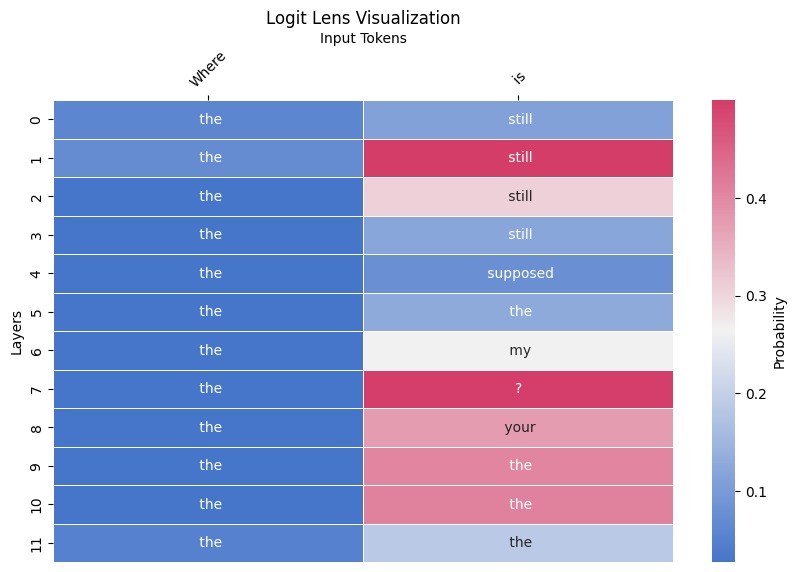

In [4]:
output_words = input_words[1:] + ["?"]

cmap = sns.diverging_palette(255, 0, n=len(words[0]), as_cmap=True)

plt.figure(figsize=(10, 6))
ax=sns.heatmap(max_probs.cpu().detach().numpy(), annot=np.array(words), fmt='', cmap=cmap, linewidths=.5, cbar_kws={'label': 'Probability'})

plt.title('Logit Lens Visualization')
plt.xlabel('Input Tokens')
plt.ylabel('Layers')

plt.yticks(np.arange(len(words)) + 0.5, range(len(words)))

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position("top")
plt.xticks(np.arange(len(input_words)) + 0.5, input_words, rotation=45)

plt.show()